In [1]:
import os
import torch
import numpy as np

from joblib import load
from torch.nn import DataParallel
from util.figplot import plot_ground
from util.prep_data import InputNormalizer, return_to_time
from util.HNO_GNO_sr import UNO3D
from util.eval import evaluate

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device('cuda')
device_ids = [0]

In [2]:
nx, ny, nz = 128, 128, 64
x, y, z = torch.linspace(0, 5000, nx), torch.linspace(0, 5000, ny), torch.linspace(0, 5000, nz)
xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')

in_channels = 5
width = 32

In [3]:
model = UNO3D(in_channels+3, width, pad=0)
model = model.to(device)
model = DataParallel(model, device_ids=device_ids)
model.load_state_dict(torch.load("../model/HNO_GNO_3D.pth"))

x_standardizer = load("../model/x_standardizer_surf.sav")
y_standardizer = load("../model/y_standardizer_surf.sav")

In [4]:
data_in = torch.from_numpy(np.load("../data/input_sr.npy"))
data_out = torch.from_numpy(np.load("../data/output_sr.npy"))
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        data_in,
        data_out),
    batch_size=1,
    shuffle=False)
test_scrxyz = np.load("../data/src_sr.npy")

In [5]:
pred = evaluate(model, data_loader)
pred = y_standardizer.decode(pred)
data_out = y_standardizer.decode(data_out)
data_in = x_standardizer.decode(data_in)

vs = data_in[0, :, :, :, 1]
vp_vs_ratio = data_in[0, :, :, :, 0] / data_in[0, :, :, :, 1]

true, pred = return_to_time(data_out), return_to_time(pred)

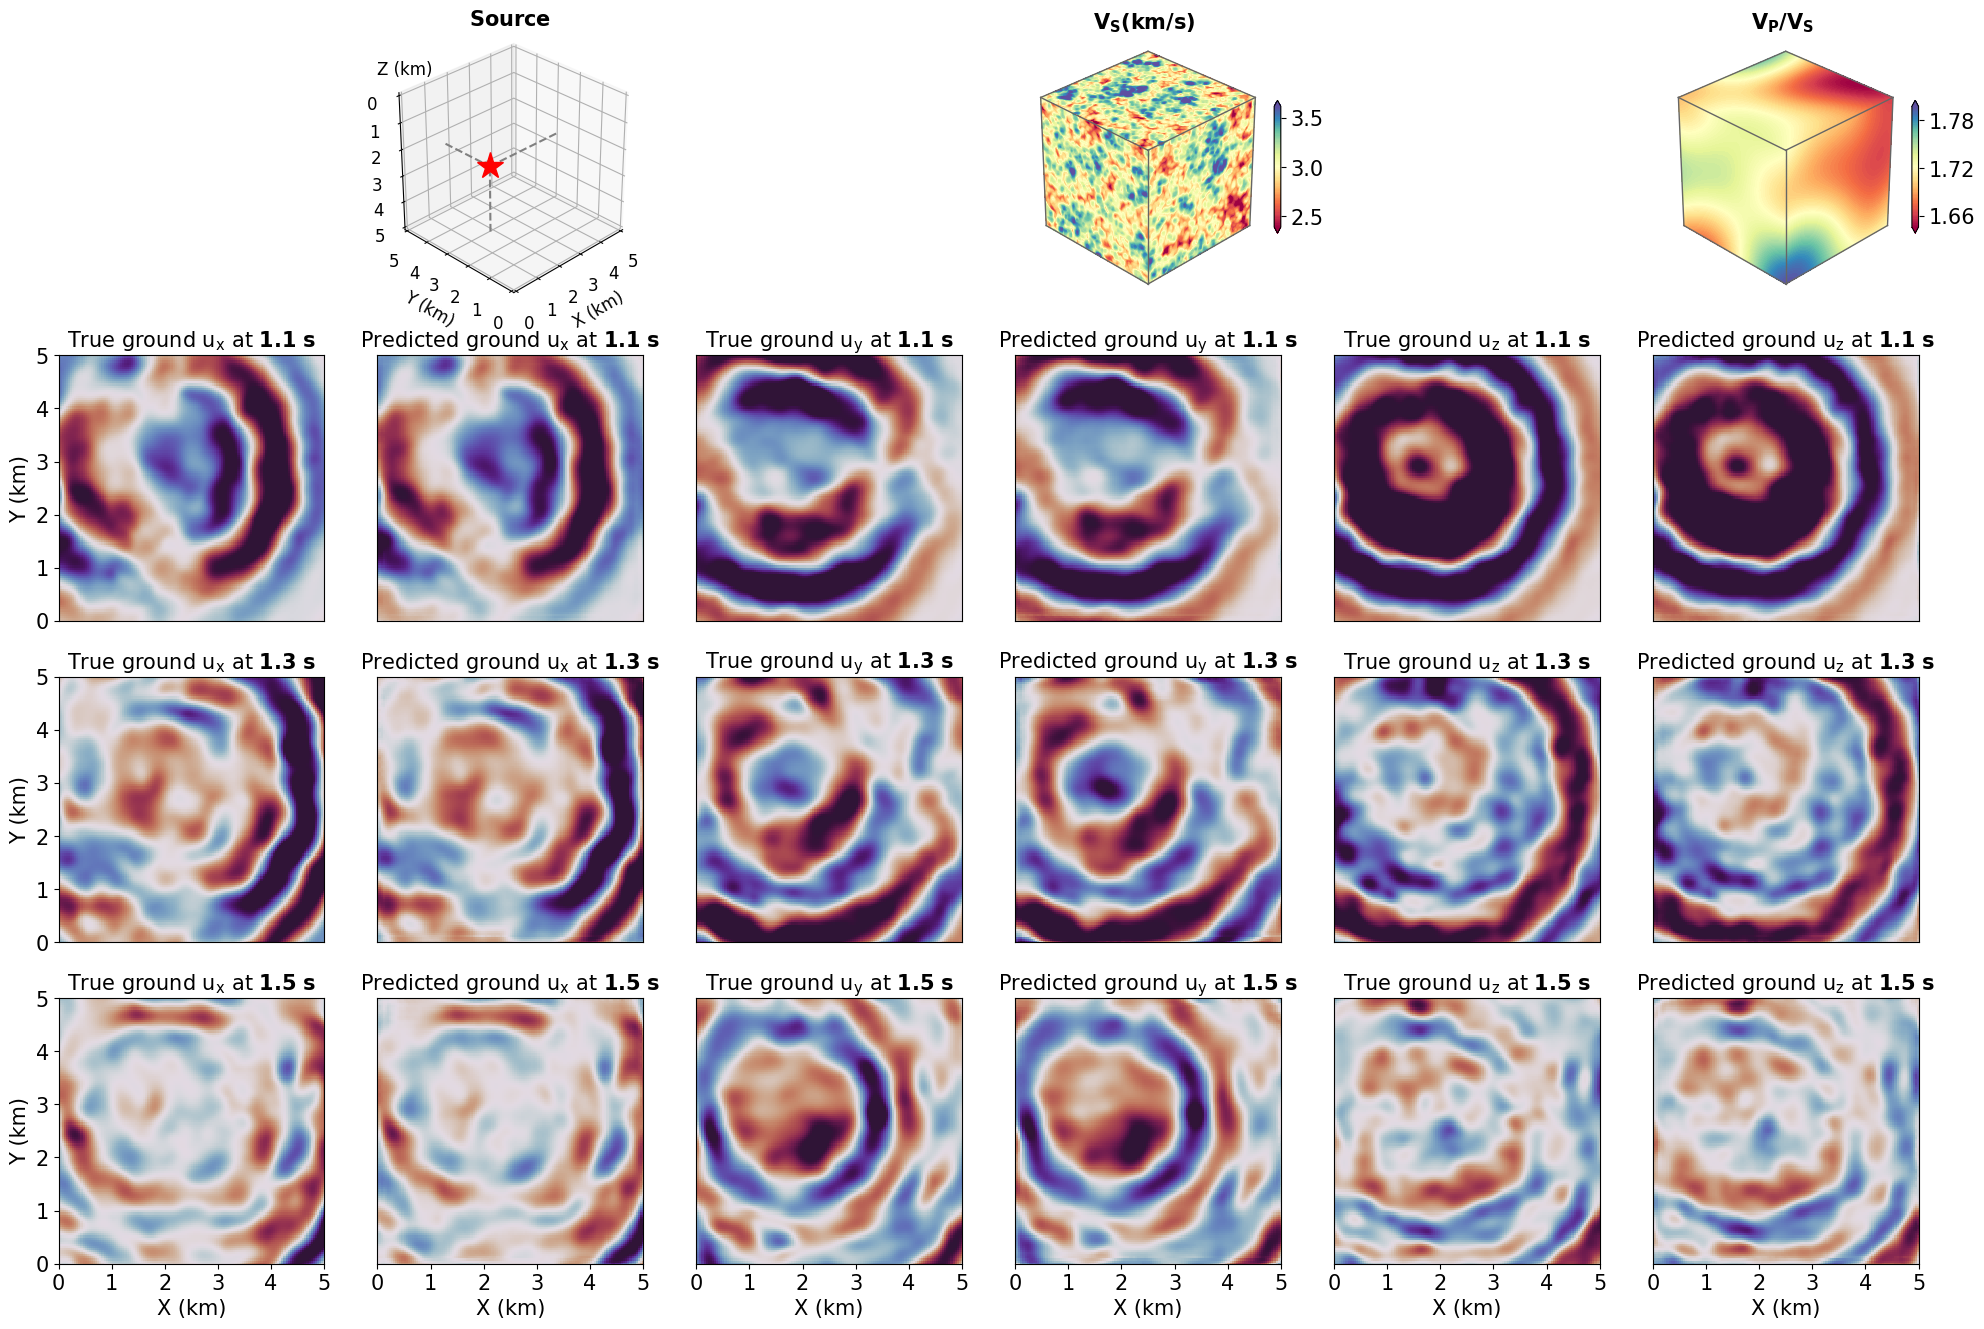

In [6]:
plot_ground(test_scrxyz, vs, vp_vs_ratio, true[0], pred[0], xx, yy, zz)